# Twin-Delayed Deep Deterministic Policy Gradients

Authors: Eshan Savla (Mtr-Nr. 91543), Raphael Aberle (Mtr-Nr. 91386), Leo Schäfer (Mtr-Nr. 91430)

<br>
This Jupyter Notebook gives an overview to the Twin-Delayed Deep Deterministic Policy Gradients (TD3).


**Table of contents**:

1. Introduction
2. From TD3 to DDPG <br>
   2.1. Motivation of TD3 <br>
   2.2. Major differences bettween DDPG and TD3 <br>
      2.2.1. Clipped double Q-Learning <br>
      2.2.2. Target policy smooting <br>
      2.2.3. Delayed policy update <br>
      2.2.4. Overview
3. Our TD3 implementation <br>
   3.1. RL extension <br>
   3.2. Hyperparameters <br>
   3.3. Training <br>
   3.3. Enjoy 
4. Test environment - Ant-v3
5. Usage of RL TD3 algorithm <br>
   5.1. Training<br>
   5.2. Enjoy
6. Benchmark - Discussion <br>
   6.1. Our TD3 vs. DDPG <br>
      6.1.1. Learning phase <br>
      6.1.2. Trained model <br>
   6.2. TD3 trained model - Hyperparameter tests <br>
   6.3. Our TD3 Best vs. Stable Baselines
7. Summary 
8. Further material

<br> 
<p>

**Info**: 
- Add mathematical equations from spinning up in the markdown and then the implementation (reference to code lines)

- - - 

## **1. Introduction**
This notebook aims to provide a comprehensive understanding of TD3 and its implementation. It includes explanations of the algorithm, code snippets, and discussions on benchmarking and performance.

Please note that this notebook assumes familiarity with reinforcement learning concepts and algorithms. If you are new to RL, it is recommended to first study the basics of DDPG before diving into TD3.

Let's get started!


## **2. From DDPG to TD3**

The TD3 Algorithm, being a direct successor to the DDPG Algorithm, introduces several enhancements. <br>
Therefore, this chapter provides an overview of the motivations behind these extensions in the TD3 Algorithm and points out the major differences between the two algorithms.


### 2.1. Motivation of TD3

The Deep Deterministic Policy Gradient (DPPG) deals with the folowing issues: 
- Overestimation Bias: DDPG tends to overestimate the Q-Values from the Q-Value function with it's one critic network 
    - The Q-Value approximator sometimes develops an incorrect sharp peak for some actions
    - The policy will quickly exploit that peak --> brittle and incorect behaviour
    

- High sensitivity to hyperparameter: DDPG reacts strongly to changes in hyperparameters

- Exploration is limited: Exploration is inherent difficult for the DDPG Agent

- Limited robustness while learning: The learning is relatively unstable. Larger samples sizes are needed for stability.

### 2.2. Major differences bettween DDPG and TD3

The fundamental task of TD3 is to minimize the overestimation of Q-values and to generate more stable learning behavior. To achieve this, three modifications are proposed for TD3.

#### 2.2.1. Clipped double Q-Learning

- TD3 learns two Q-functions instead of one (hence “twin”)

- The smaller Q-value is used to form the targets in the Bellman error loss functions

$$ y(r,s',d) = r + \gamma(1 - d) \min_{i =  1,2} (Q{\phi_{i,targ}}(s',a'(s'))) $$

#### 2.2.2. Target policy smoothing
- The Target policy smoothing combats the exploitation of errors from the Q-Value approximator

- Clipped noise is added to the target action $a'(s')$ during the policy update process

$$ a'(s') = clip(\mu_{\theta_{targ}}(s')+clip(\epsilon,-c,c),a_{Low},a_{High}), \epsilon{\sim}N(0,\sigma) $$

- DDPG adds noise only in output action

- This addition of noise makes it harder for the policy to exploit Q-function errors by smoothing out Q along changes in action

- This results in a more robust and stable learning behavior

- For a higher-quality training reducing the scale of the noise of the target action over the course of training is an option

#### 2.2.3. Delayed policy update
- TD3 updates the policy (and target networks) less frequently than the Q-function --> increases stability

- the original paper of the TD3-Alogrithm recommends one policy (and target) update for every two Q-function updates

- original wording: IF target networks can be used to reduce the error over multiple updates, and policy updates on high-error states cause divergent behavior, then the policy network should be updated at a lower frequencey than the value network, to first minimize error before introducing a policy update. We propose delaying policy updates until the value error is as small as possible. [...] The less frequent policy updates that do occur will use a value estimate with lower variance, and in principle, should result in higher quality policy updates. -> generates a "two-timescale" algorithmen.

#### 2.2.4. Overview
The resulting structure of the TD3-Algoithm is shown below:<br> <br>
<img src="./images/td3_overview.png" alt="td3_overview" width="1000"/>




- - - 
## **3. Our TD3 implementation**

For a better structure, the algorithm implementations are seperated into multiple classes and files, which are attached to this notebook. <br>
For a more detailed explanations of the whole code, check the comments of the source code files.
### 3.1. Extension of TD3-alogrithm


The below shown Pseudocode gives an overview to the fundamental changes of our chnages made for TD3 compared to DDPG. <br>

<img src="./images/pseudocode.jpg" alt="td3_overview" width="500"/>

The following code snippets show the extensions made for TD3 implementation. For better stucture each method of TD3, which is different to DDPG-Algorithm, is considered seperately. <br>
The three major changes of the TD3 implementation in contrast to the DDPG implementation are highlighted by different colors for each extension: <br>
- <span style="color:Tomato">**Clipped double Q-Learning**</span>
- <span style="color:MediumSeaGreen">**Target policy smoothing**</span>
- <span style="color:DodgerBlue">**Delayed policy update**</span>

In the init method a trainable critic network and a critic target network is added. Both of them are initialized. Additionally another noise generator for the target policy smoothing is initialized.<br><br>
<img src="./images/init_method.png" alt="init_method" width="1000"/>

For the added networks the weights are set like for the other networks: <br><br>
<img src="./images/init_network_method.png" alt="init_method" width="1000"/>


Here, noise is added to the target action for smoothing the Q-value function by preventing the exploitation of q-value-function errors. <br>
The reduction of the noise scale improves the training quality. To combat overestimation the minimum of the caluclated Q-values is selected fo the critic loss calculation. <br><br>
<img src="./images/compute_q_target_method.png" alt="init_method" width="1000"/>

The actor network and the target networks are only updated every n-step defined by the policy_freq parameter. <br><br>
<img src="./images/learn_method.png" alt="init_method" width="1000"/>
<img src="./images/target_update_method.png" alt="init_method" width="1000"/>

### 3.2. Hyperparameters

The hyperparameters are one way of influencing the algorithm and model quality. 

**General parameters:​**
- Discount factor (γ) -> immediate rewards > future rewards​
  - value range: 0 - 1 => higher values emphasize long-term rewards
- Learning-rate (lr)  -> learning rate for neural network optimizer
  - Determines the size of steps taken​ during the optimization process during updates
- ε-greedy (ε)        -> random action with ε-probability for exploration​
- Update weight (τ)   -> how much target network is updated
  - Determines the rate of updating the target networks. It is slowly to reduce the variance in learning and prevent overly influence of most recent experiences 
  
**TD3 specific parameters:​**
- Target action noise (σ) -> smoothing q-function by adding noise to action​
  - It combats overfitting and prevents the learning process to become too reliant on current policy estimes 
- Update frequency        -> Update rate of actor and target networks​
  - Usually, the policy and target networks get updated every second update of the critic network

<br>
During the implementation of TD3, we've integrated further parameters to improve the model results. 


**Further parameters:​**
- Noise reduction -> reduce noise over time steps​
  - The noise gets reduces over ascending timesteps in a e-function.
- Min noise factor   -> max noise reduction
  - Introduced to maintain a minimum noise within higher time steps. 
<br>

- - -

## **4. Test environment - Ant-v3**

A benchmark of different algorithms requires an environment. 
Consequently, this chapter describes the used test environment "Ant-v3" from MuJoCo. MuJoCo stands for Multi Joint dynamics with Contact.

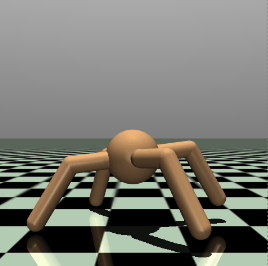


**- Action Space​**
  - Ant with 4 legs
  - 2 joints in each leg -> 8​ in total
  - It is possible to apply a continuous torque from -1 to 1 Nm​
<br>

**- Observation Space​**
  - 27 – 29 (extended) observations​
    - Positions of the torso (x, y, z)
    - velocities (in x-, y-, z-direction) 
    - angles (around x, y, z)
    - angular velocities ​(around the x-, y-, z-axis)

**- Reward​**
  - An important element in Reinforcement learning is the Reward.
  - In Ant-v3 the reward is defined as:
     reward = healthy_reward + forward_reward - ctrl_cost - contact_cost​

     - healthy_reward: Is received every timesteps the torso is within the healthy_z_range (default: [0,2:1]) 
     - forward_reward: Motion in x-direcetion is rewarded (aim: as fast as possible)
     - ctrl_cost: Negative reward is received if the taken actions are to large (ctrl_cost_weight * sum(action²)      => df = 0.5)
     - contact_cost: Negative reward is received if the external contact force is too large (jumping etc.) => contact_cost_weight * sum(clip(external contact force to contact_force_range)²)​

​
**- Episode end​**
  - Any state space value is no longer finite​
  - Truncation: The z-coordinate of the torso is not in the defined interval (default: [0,2:1])
  - Termination: The episode duration reaches 1000 timesteps


For further informations, please review: https://www.gymlibrary.dev/environments/mujoco/ant/

<br>

- - -

## 5. Usage of RL TD3 algorithm 

For better performance execute the files from the repository directly. <br>
We experienced that the execution in the notebook is quite slow and lead to problems with mujoco

### 5.1. Training
For a better overview of hyperparameter sets used for training the hydra library is used, in order to load hyperparameter sets from config files.<br>
A new config file for changing the hyperparameters could be created by copying one of the existing ones in the config folder and ajust it's values.<br>

In [3]:
import hydra
from hydra.utils import instantiate
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import timeit
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.insert(0, '../src') # DO NOT CHANGE

import gymnasium as gym
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from td3 import TD3Agent
from replay_buffer import ReplayBuffer
from functions import compute_avg_return

2024-01-15 23:22:45.302407: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 23:22:45.302449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 23:22:45.303872: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-15 23:22:45.310814: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-15 23:22:46.074283: W tensorflow/compiler/tf2

The config file that should be used for training could be specified like this:

In [ ]:
config_name = "config"
with hydra.initialize(config_path="../configs/", job_name="td3_config"):
    cfg = hydra.compose(config_name=config_name) # Option to test multiple configurations: Change the config name to your desired config file

This is the main function for training the agent.

In [ ]:

def main_training(load_replay_buffer=True):
    physical_devices = tf.config.list_physical_devices('GPU') 
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    replay_buffer = instantiate(cfg.ReplayBuffer)
    env = gym.make('Ant-v3', max_episode_steps=1000,autoreset=True, render_mode='rgb_array') #human 
    agent = TD3Agent(env.action_space, env.observation_space.shape[0],gamma=cfg.TD3Agent.gamma,tau=cfg.TD3Agent.tau, epsilon=cfg.TD3Agent.epsilon, noise_clip=cfg.TD3Agent.noise_clip, policy_freq=cfg.TD3Agent.policy_freq)
    if type(cfg.TD3Agent.use_checkpoint_timestamp) == bool and cfg.TD3Agent.use_checkpoint_timestamp:
        print("Loading most recent checkpoint")
        agent.load_weights(use_latest=True)
        if load_replay_buffer:
            replay_buffer.load(agent.save_dir)
    elif not cfg.TD3Agent.use_checkpoint_timestamp:
        print("No checkpoint loaded. Starting from scratch.")
    else:
        print("Loading weights from timestamp: ", cfg.TD3Agent.use_checkpoint_timestamp)
        agent.load_weights(load_dir=os.path.join(cfg.TD3Agent.weights_path, cfg.TD3Agent.use_checkpoint_timestamp+'/'), use_latest=False)
        if load_replay_buffer:
            replay_buffer.load(agent.save_dir)
    total_timesteps = cfg.Training.start
    returns = list()
    actor_losses = list()
    critic1_losses = list() 
    critic2_losses = list()
    evals_dir = None
    first_training = True
    eval_count = 0
    with tqdm(total=cfg.Training.timesteps, desc="Timesteps", leave=True) as pbar:
        while total_timesteps <= cfg.Training.timesteps:
            obs, _ = env.reset()
            # gather experience
            agent.noise_output_net.reset()
            agent.noise_target_net.reset()

            ep_actor_loss = 0
            ep_critic1_loss = 0
            ep_critic2_loss = 0
            steps = 0
            for j in range(1000):
                steps += 1
                action = agent.act(np.array([obs]), random_action=(total_timesteps < cfg.Training.start_learning)) # i < 1 no policy for first episode
                # execute action

                # Patching terminated/truncated state behaviour based on issue:
                # https://github.com/Farama-Foundation/Gymnasium/pull/101
                # and
                # https://github.com/openai/gym/issues/3102
                new_obs, r, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                if steps >= 1000:
                    episode_truncated = not done or info.get("TimeLimit.truncated", False)
                    info["TimeLimit.truncated"] = episode_truncated
                    # truncated may have been set by the env too
                    truncated = truncated or episode_truncated
                    done = terminated or truncated
                replay_buffer.put(obs, action, r, new_obs, done)
                obs = new_obs
                if done:
                    break
               
            total_timesteps += steps
            
            if total_timesteps >= cfg.Training.start_learning:      
            # Learn from the experiences in the replay buffer.
                for s in range(cfg.Training.batch_size):
                    s_states, s_actions, s_rewards, s_next_states, s_dones = replay_buffer.sample(cfg.Training.sample_size, cfg.Training.unbalance)
                    actor_l, critic1_l, critic2_l = agent.learn(s_states, s_actions, s_rewards, s_next_states, s_dones,s, total_timesteps)
                    ep_actor_loss += actor_l
                    ep_critic1_loss += critic1_l
                    ep_critic2_loss += critic2_l
                if eval_count % 25 == 0 or first_training:
                    first_training = False
                    avg_return, _ , _, _ , _ = compute_avg_return(env, agent, num_episodes=5, max_steps=1000, render=False)
                    print(
                        f'Timestep {total_timesteps}, actor loss {ep_actor_loss / steps}, critic 1 loss {ep_critic1_loss / steps}, critic 2 loss {ep_critic2_loss/steps} , avg return {avg_return}')
                    agent.save_weights()
                    replay_buffer.save(agent.save_dir)
                if evals_dir is None:
                    evals_dir = '../evals/'+ agent.save_dir.split('/')[-2] + "/"
                    os.makedirs(evals_dir, exist_ok=True)   # create folder if not existing yet
                returns.append(avg_return)
                actor_losses.append(tf.get_static_value(ep_actor_loss) / steps)
                critic1_losses.append(tf.get_static_value(ep_critic1_loss) / steps)
                critic2_losses.append(tf.get_static_value(ep_critic2_loss) / steps)
                df = pd.DataFrame({'returns': returns, 'actor_losses': actor_losses, 'critic1_losses': critic1_losses, 'critic2_losses': critic2_losses})
                plot_losses = df.drop("returns", axis=1, inplace=False).plot(title='TD3 losses', figsize=(10, 5))
                plot_losses.set(xlabel='Epochs', ylabel='Loss')
                plot_losses.get_figure().savefig(evals_dir+'losses_td3.png')

                returns_df = pd.DataFrame({'returns': returns})
                plot_returns = returns_df.plot(title='TD3 returns', figsize=(10, 5))
                plot_returns.set(xlabel='Epochs', ylabel='Returns')
                plot_returns.get_figure().savefig(evals_dir+'returns_td3.png')
                plt.close('all')
                df.to_csv(evals_dir+'td3_results.csv', index=True) 
                eval_count += 1
            pbar.update(steps)


    agent.save_weights()
    replay_buffer.save(agent.save_dir)
    
    env.close()

Execute the training with the current loaded config:

In [ ]:
elapsed_time = timeit.timeit(lambda: main_training(load_replay_buffer=True), number=1)
minutes, seconds = divmod(elapsed_time, 60)
print(f"The main function ran for {int(minutes)} minutes and {seconds:.2f} seconds.")


### 5.2. Enjoy

After training or by loading pretrained models, the agent can be evaluated by the main_enjoy-function.



In [ ]:
from ddpg import DDPGAgent
from td3 import TD3Agent
import os
import gymnasium as gym
from functions import compute_avg_return
import pandas as pd

In [ ]:

def main_enjoy(agent_type:str, load_dir=None, use_latest = True):
    """
    Run the main evaluation loop for the specified agent type.

    Parameters:
    - agent_type (str): The algorithm/agent type ("ddpg" or "td3").
    - load_dir (str): The path to the model you want to evaluate. Ignored if use_latest is True.
    - use_latest (bool): True if you want to use the latest checkpoint.

    Returns:
    None
    """
    env = gym.make('Ant-v3', autoreset=True, render_mode = "human")
    if agent_type == "ddpg":
        from ddpg_config import cfg as ddpg_cfg, config_name
        agent = DDPGAgent(env.action_space, env.observation_space.shape[0],gamma=ddpg_cfg.DDPGAgent.gamma,tau=ddpg_cfg.DDPGAgent.tau, epsilon=0)
    elif agent_type == "td3":
        from td3_config import cfg as td3_cfg, config_name
        agent = TD3Agent(env.action_space, env.observation_space.shape[0],gamma=td3_cfg.TD3Agent.gamma,tau=td3_cfg.TD3Agent.tau, epsilon=0)
    else:
        raise ValueError("Invalid agent type")
    agent.load_weights(load_dir=load_dir, use_latest=use_latest)
    obs, _ = env.reset()
    avg_return, avg_return_stddev, episode_no, returns, stddevs = compute_avg_return(env, agent, num_episodes=2, max_steps=1000, render=False)
    
    print(f"Average return: {avg_return}, Standard deviation: {avg_return_stddev}")
    time_stamp = agent.save_dir.split("/")[-2]
    user_name = os.getlogin()
    df = pd.DataFrame({"file": [config_name], "time_stamp": [time_stamp], "user_name": [user_name], "agent_type": [agent_type], "avg_return": [avg_return], "return_stddev": [avg_return_stddev], "episode_no": [episode_no], "returns": [returns], "stddevs": [stddevs]})
    df.to_csv("../benchmarks_test.csv", mode="a", header=False, index=False)
    env.close()

Execute the enjoy here, by specifying the following parameters: <br>
- the training algorithm
- the directory of the trained model for the evaluation
- a flag, whether the function should just use the latest_trained model

In [ ]:
main_enjoy("td3")  #speficy the algorithm/ agent type ("ddpg" or "td3"), specify the path to the model you want to evaluate. For more information: see Mapping_mod-conf.md,  True if you want to use the latest checkpoint     

### 5.3 Evaluation

For evaluation purposes, we save average returns and losses in cvs files while training. For the benachmark tests the return in each episode and the standard deviation of the returns is saved in a csv file. Both files can be evaluated using the evaluate.py file


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

from functions import flatten
import datetime
import numpy as np
import datetime
from scipy import stats
import os

In [ ]:
def evaluate_enjoy(data_path_csv:str = 'benchmarks_test.csv', plot_type: str = 'bar', only_avgs:bool = False):

    # Read the data from the CSV file
    data = pd.read_csv(data_path_csv) #'benchmarks_test.csv'
    avg_return = data['avg_return']
    # Convert the string representation of lists into actual lists of floats
    data['returns'] = data['returns'].apply(ast.literal_eval)
    data['stddevs'] = data['stddevs'].apply(ast.literal_eval)
    data['episode_no'] = data['episode_no'].apply(ast.literal_eval)
        
    if isinstance(data['episode_no'], str):
        episode_no = ast.literal_eval(data['episode_no'])

    data['stddevs'] = data['stddevs'].apply(flatten)

    # Calculate the mean of the lists in 'stddevs' column
    data['stddevs'] = data['stddevs'].apply(np.mean)

    # Now group the data and calculate the mean standard deviation per episode over all experiments
    mean_stddev_per_episode = data.groupby(['time_stamp', 'config_name', 'user_name', 'agent_type'])['stddevs'].mean()

    # Update y1 and y2 values
    data['y1'] = data.apply(lambda row: np.mean(row['returns']) + mean_stddev_per_episode[(row['time_stamp'], row['config_name'], row['user_name'], row['agent_type'])], axis=1)
    data['y2'] = data.apply(lambda row: np.mean(row['returns']) - mean_stddev_per_episode[(row['time_stamp'], row['config_name'], row['user_name'], row['agent_type'])], axis=1)

    # Create a Linegraph with x-axis = episode, y-axis=returns per episode
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    if plot_type.lower() == 'line':
        fig, ax = plt.subplots()

        for i, row in data.iterrows():
            episode_no = row['episode_no']
            returns = row['returns']
            stddevs = row['stddevs']
            
            # Convert the list into a string representation
            episode_no_str = str(episode_no)
            # Convert the string representation of episode numbers into actual list of floats
            episode_no = ast.literal_eval(episode_no_str)
            
            # Plot the returns per episode
            #label = f'{row["time_stamp"]} - {row["config_name"]} - {row["user_name"]} - {row["agent_type"]}'
            label = f' {row["agent_type"]}-{row["config_name"]}'
            label_means = f'{row["agent_type"]}-{row["config_name"]}-mean'
            
            if not only_avgs:
                ax.plot(episode_no, returns, label=label)
            ax.plot(episode_no, [row["avg_return"] for i in range(len(returns))], label=label_means)
            
            # Add a subplot using fill_between
            if not only_avgs:
                ax.fill_between(episode_no, np.array(returns) + np.array(stddevs), np.array(returns) - np.array(stddevs), alpha=0.3)
            ax.fill_between(episode_no, np.array([row["avg_return"] for i in range(len(returns))]) + np.array([row["avg_return_stddev"] for i in range(len(returns))]), np.array([row["avg_return"] for i in range(len(returns))]) - np.array([row["avg_return_stddev"] for i in range(len(returns))]), alpha=0.3)

        # Set the labels and title and legend
        ax.set_xlabel('Episode')
        ax.set_ylabel('Returns per Episode')
        ax.set_title('Returns per Episode for different configurations')
        ax.legend()
        
        # Show the plot
        #plt.show()
        
        # Save the plot with the timestamp in the file name
        fig.savefig(f'{timestamp}_returns_per_episode.png')

    if plot_type.lower() == 'bar':
        color=['green', 'blue', 'blue', 'gold', 'gold', 'darkred',  'darkred', 'darkgreen', 'darkorchid', 'darkorchid', 'cadetblue']
        X = data['config_name']
        Y = data['avg_return']
        t = type(Y)
        yerr = data['avg_return_stddev']
        fig, ax = plt.subplots()
        fig.set_figheight(10)
        fig.set_figwidth(25)
        ax.bar(X, Y, yerr=yerr, align='center', color=color[0:len(X)], ecolor='black', capsize=10)
        ax.set_title('Average Return per Configuration', fontsize=25)
        ax.set_ylabel('Average Return', fontsize=25)
        ax.set_xlabel('Configuration', fontsize=25)
        ax.set_xticklabels(X, rotation=45, fontsize=20)
        ax.tick_params(axis='y', labelsize=20)
        fig.tight_layout()
        fig.savefig(f'{timestamp}_avg_return_per_config.png')


def evaluate_training(training_data_path_csv = training_data_path_csv):
    # Load the training data from the CSV file
    training_data = pd.read_csv(training_data_path_csv)
    # Plot actor loss over time
    plt.figure()
    plt.plot(training_data['Unnamed: 0'], training_data['actor_losses'], color = "blue",label='Actor Loss')
    plt.xlabel('Steps')
    plt.ylabel('Actor Loss')
    plt.title('Actor Loss over Time')
    # Visualize a trend line
    x = training_data['Unnamed: 0']
    y = training_data['actor_losses']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), "r--", label='Trend Line') 
    plt.xticks(range(0,10, 100000))

    # Add legend
    plt.legend()
    plt.title('Actor Loss over Time')
    # Save plot
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
    filename = f"{training_data_path_csv}_{timestamp}_actor_losses.png"
    plt.savefig(filename)

    # Plot critics loss over time
    plt.figure()

    x1 = training_data['Unnamed: 0']
    y1 = training_data['critic1_losses']
    plt.plot(x1, y1, label='Critic1 loss', color='red')
    plt.xticks(range(0,10, 100000))
    plt.set_xlabel(range(0,100000, 100000))

    x2 = training_data['Unnamed: 0']
    y2 = training_data['critic2_losses']
    plt.plot(x2, y2, label='Critic2 loss')
    plt.xticks(range(0,10, 100000))

    # Calculate and plot trend line for critics loss
    slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2, y2)
    plt.plot(x2, intercept2 + slope2*x2, 'g--', label='Trend line 2')
    plt.xticks(range(0,10, 100000))


    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1, y1)
    plt.plot(x1, intercept1 + slope1*x1, 'r--', label='Trend line 1')
    plt.xticks(range(0,10, 100000))
    
    # Set labels and title
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Critic Losses over Time')

    # Add a legend
    plt.legend()

    # Save the plot
    plt.savefig(f"{training_data_path_csv}_{timestamp}_critic_losses.png")

Execute the following code to view the training evaluation:

In [ ]:
# Set the path to the csv file to evaluate the training results
training_data_path_csv = '../models/ddpg_gt/ddpg_results.csv'
evaluate_training(training_data_path_csv=training_data_path_csv)

Execute the following code to view the enjoy evaluation:

In [ ]:
#Set the path to the csv file to evaluate the benchmark results
data_path_csv = '../benchmarks_td3_test_hp.csv'
evaluate_enjoy(data_path_csv=data_path_csv)

- - -
## **6. Benchmark - Discussion**

### 6.1.

To compare the two algorithms we've defined a basic parameter set, so-called Ground Truth. 

The below shown graphic gives an overview to the Ground Truth parameters: 

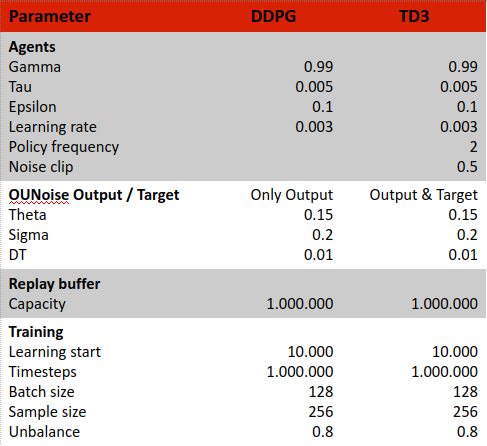


#### 6.1.1. Learning phase

**Actor losses over time:** <br>
-------------------------------------------- **DDPG** -------------------------------------------- |--------------------------------------------- **TD3** ---------------------------------------------

<img src="images/ddpg_results.csv_2024-01-15-20-42_actor_losses.png" width="500"> <img src="images/td3_results.csv_2024-01-15-20-40_actor_losses.png" width="500">

- Delayed policy updates lead to more stable actor training losses ​
  - This gets visible by the comparison of the success and precessor actor losses of the two algorithm. The relative difference is smaller in TD3 than in DDPG. 

<br>


**Critics losses over time:** <br>
-------------------------------------------- **DDPG** -------------------------------------------- |--------------------------------------------- **TD3** ---------------------------------------------

<img src="images/ddpg_results.csv_2024-01-15-20-42_critic_losses.png" width="500"> <img src="images/td3_results.csv_2024-01-15-20-40_critic_losses.png" width="500">


- Double Q learning combats overestimation successfully 
  - This gets visible in the critic training losses of TD3. By using the minimum of the two critic losses, the overestimation is tackled. The arithmetic average difference is 0.92% leading to a successful improve. ​
- Added target policy noise smoothens exploitation of a possible q-function error ​

<br>
During the implementation, we've changed two further points: <br>

- The training phase is now only based on the training steps, instead of a combination of epochs and steps. 
  This ensures that the complete training budget is used. 
- Otherwise a early episode stop would decrease the total amount of training steps. ​
- Our learning starts first after 10.000 training steps. 
  The delayed learning start stabilizes and optimizes the training​ as the algorithm collected more first experience. 



#### 6.1.2. Trained model

The performance of the trained models can be quantified by the average return and standard deviation. 

We've evaluated the average of 150 episodes, leading to the following result: 

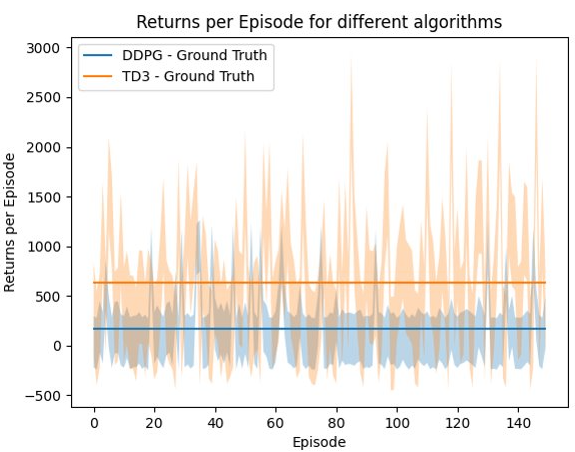

|                    | DDPG | TD3 |
|---                 |---   |---  |
| average return     |  170 | 631 |
| standard deviation |  259 | 470 |


Consequently, the applied algorithm changes lead to a remarkably increased performance in the average returns of factor ~3,7 by a standard deviation increase factor of ~1,8. <br>

#### 6.1.3 Untrained models
In order to evaluate the performance of our models, their performance was compared to that of untrained ddpg and td3 agents. The following graph shows how these untrained agents perform in the same environment by carrying out entirely random actions along all joints.

<img src="images/returns_untrained.png" width="500">

| Untrained returns  | DDPG | TD3 |
|---                 |---   |---  |
| average return     | 773  | 761 |
| standard deviation | 167  | 198 |

Considering only the empirical implications of these results without considering the qualitative aspects of the actions carried out by these untrained agents, suggests that carrying out entirely random actions seems to be more profitable than attempting to traverse the environment along its x axis as fast as possible. This leads to the suggestion, that the selected hyperparameters of the grount truths were not optimal to maximize returns and paves the way to carrying out more detailed hyperparameters tests to improve the performance of these models



### 6.2. TD3 Trained model - Hyperparameter tests 

Compared to the ground truth, various isolated permutations of the hyperparameters have shown the following result: 

<img src="images/2024-01-16_00-12_avg_return_per_config.png" width=800>

A review of the graph suggests that an isolated increase of tau and of the learning rate have the biggest influence. <br>

As the influence of the learning is higher than the one of tau, the following evaluation concentrates on models with a learning rate of 0.001. <br>

Additional permutations of the noise have show that a combination of a higher learning rate and a higher noise lead to a remarkable increase in the average reward of a trained model. Increasing the tau value in this situation led to lower average returns

Building on this, the policy noise was reduced using a negative exponential function over time to provide adequate noise towards the initial and medial stages while ensuring a rapid drop in noise towards the final stages of training. This form of noise reduction led to drastic improvements in the average returns


### 6.3. Our TD3 Best vs. Stable Baselines

<br>A comparision of the performance of our best model with that from stable baselines shows, that our average returns lag behind by a margin of less than 500. [Stable baselines](https://stable-baselines.readthedocs.io/en/master/#) refers to a library of pre-trained reinforcement learning models which can be used as benchmarks. The implementation of these algorithms is based off of the guidlines set by OpenAi.<br>

The performance was benchmarked using a budget of 150,000 steps (150 Episodes of 1,000 steps each).

The result of this benchmark can be visualized as follows: <br>

<img src="images/td3_baselines_best_gt_ddpg_gt.png" width = 500>



| Model                | Average return | Standard deviation |
|---                   |---             |---                 |
| DDPG Ground Truth    |     170        |      259           |
| TD3 Ground Truth     |     631        |      470           |
| TD3 Best model       |     5354       |      767           |
| TD3 Stable Baselines |     5813       |      589           |


**Findings**: 
- TD3 Ground Truth performs better than DDPG Ground Trouth
- The tweaking of hyperparameters has an remarkable influence to the results of the algorithm. 
- Significant improvements within the basic algorithm are possible 
- TD3 Best model reaches nearly the performance of the stable baselines one
- Reward shaping of healthy z-range would lead to increased returns ​and decreased standard deviations



- - -

## **7. Summary**

- TD3 achieved better results than DDPG through simple changes​
- Individual components contribute little to improvement(Fujimoto, et al. (2018))​
- A higher learning rate and policy noise with reduction over time greatly improved results, comparable to stable baselines​
- Noticeable reduction in training time compared to DDPG​

- More in depth studies for TD3 parameter permutations could yield even better results​
- More in depth studies for parameter permutations of DDPG could substantiate sensitivity reduction​
- Implementation requires optimization for replay buffer and parallel training



- - -

## **7. Further material**

**GitHub Repos**
- TD3-RLE: 
- Stable Baselines: https://github.com/openai/baselines
- DLR - RL Baselines Zoo: https://github.com/DLR-RM/rl-baselines3-zoo

**Environment from MuJoCo**
- Ant-v3: https://www.gymlibrary.dev/environments/mujoco/ant/

**Useful information:**
- OpenAI Spinning Up: https://spinningup.openai.com/en/latest/


<br>
<br>

==> Add helpful links
  